# Data

## Load the data

In [1]:
"""
    Download and save raw market data CSV
"""

import pandas as pd
import logging
import os

# Setup Logger
logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s", handlers=[logging.StreamHandler()])
logger = logging.getLogger(__name__)

# Download and save CSV. One time only
logger.info("Downloading power data...")
url = "https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv"
local_path = "data/power_data_raw.csv"

os.makedirs("data", exist_ok=True)

if os.path.exists(local_path):
    logger.info("File exists. Reading local CSV...")
    df = pd.read_csv(local_path)
else:
    df = pd.read_csv(url)
    logger.info("Saving to data/power_data_raw.csv")
    os.makedirs("data", exist_ok=True)
    df.to_csv("data/power_data_raw.csv", index=False)

logger.info("Process completed.")

2025-12-13 12:20:51,042 | INFO | Downloading power data...
2025-12-13 12:20:51,043 | INFO | File exists. Reading local CSV...
2025-12-13 12:20:51,476 | INFO | Process completed.


## Get Austria's Values

In [2]:
print(df.head())
with open("data/all_column_names.txt", "w") as f:
    for col in df.columns:
        f.write(f"{col}\n")

          utc_timestamp        cet_cest_timestamp  \
0  2014-12-31T23:00:00Z  2015-01-01T00:00:00+0100   
1  2015-01-01T00:00:00Z  2015-01-01T01:00:00+0100   
2  2015-01-01T01:00:00Z  2015-01-01T02:00:00+0100   
3  2015-01-01T02:00:00Z  2015-01-01T03:00:00+0100   
4  2015-01-01T03:00:00Z  2015-01-01T04:00:00+0100   

   AT_load_actual_entsoe_transparency  AT_load_forecast_entsoe_transparency  \
0                                 NaN                                   NaN   
1                              5946.0                                6701.0   
2                              5726.0                                6593.0   
3                              5347.0                                6482.0   
4                              5249.0                                6454.0   

   AT_price_day_ahead  AT_solar_generation_actual  \
0                 NaN                         NaN   
1                35.0                         NaN   
2                45.0                         N

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Columns: 300 entries, utc_timestamp to UA_load_forecast_entsoe_transparency
dtypes: float64(298), object(2)
memory usage: 115.4+ MB


## Set Index

We convert the index to Austrian Local Time ```(Europe/Vienna)``` rather than using ```UTC```. Electricity demand and prices are driven by human activity (e.g., cooking, industry start times) and solar cycles, which adhere to the local wall clock. If we utilized ```UTC```, the daily "evening peak" would shift by one hour during Daylight Savings Time transitions (appearing at 17:00 ```UTC``` in summer vs. 18:00 ```UTC``` in winter). By locking the data to Local Time, we ensure that Hour 19 consistently represents the same high-demand event year-round, preventing pattern "smearing" and simplifying the model's learning process.

In [4]:
at_cols = df.columns[df.columns.str.startswith("AT_")]
selected_cols = ["cet_cest_timestamp"] + list(at_cols) # Desired Columns
df_selected = df[selected_cols].copy()
df_selected = df_selected.drop(["AT_load_actual_entsoe_transparency"], axis=1)
df_selected["cet_cest_timestamp"] = pd.to_datetime(df["cet_cest_timestamp"], utc=True).dt.tz_convert("Europe/Vienna") # Datetime Timestamp
df_selected = df_selected.set_index("cet_cest_timestamp") # Timestamp as index
print(df_selected.head(1))

                           AT_load_forecast_entsoe_transparency  \
cet_cest_timestamp                                                
2015-01-01 00:00:00+01:00                                   NaN   

                           AT_price_day_ahead  AT_solar_generation_actual  \
cet_cest_timestamp                                                          
2015-01-01 00:00:00+01:00                 NaN                         NaN   

                           AT_wind_onshore_generation_actual  
cet_cest_timestamp                                            
2015-01-01 00:00:00+01:00                                NaN  


### We keep only the columns that we are interested in. We keep the actuals that do not have a forecast to lag them by 48 hours. The actuals that have a forecast columns are dropped.

## Enforce Hourly Frequency

In [5]:
full_idx = pd.date_range(
    start=df_selected.index.min(),
    end=df_selected.index.max(),
    freq="h",
    tz=df_selected.index.tz
)
df_selected = df_selected.reindex(full_idx)

## Slice the Dataset to Valid start and finish

In [6]:
important_cols = ["AT_load_forecast_entsoe_transparency", "AT_price_day_ahead", "AT_wind_onshore_generation_actual", "AT_solar_generation_actual"]

In [7]:
first_valid_indices = df_selected[important_cols].apply(lambda col: col.first_valid_index())
last_valid_indices = df_selected[important_cols].apply(lambda col: col.last_valid_index())

print("First valid data points:")
print(first_valid_indices)

First valid data points:
AT_load_forecast_entsoe_transparency   2015-01-01 01:00:00+01:00
AT_price_day_ahead                     2015-01-01 01:00:00+01:00
AT_wind_onshore_generation_actual      2015-01-01 01:00:00+01:00
AT_solar_generation_actual             2015-01-01 08:00:00+01:00
dtype: datetime64[ns, Europe/Vienna]


In [8]:
print(last_valid_indices)

AT_load_forecast_entsoe_transparency   2020-10-01 01:00:00+02:00
AT_price_day_ahead                     2018-10-02 23:00:00+02:00
AT_wind_onshore_generation_actual      2020-10-01 01:00:00+02:00
AT_solar_generation_actual             2020-09-30 19:00:00+02:00
dtype: datetime64[ns, Europe/Vienna]


In [9]:
global_start = first_valid_indices.max()
global_end = last_valid_indices.min()

print(f"\nSlicing Data to Common Range: {global_start} to {global_end}")


Slicing Data to Common Range: 2015-01-01 08:00:00+01:00 to 2018-10-02 23:00:00+02:00


In [10]:
df_clean = df_selected.loc[global_start: global_end].copy()
print(df_clean.isna().sum())

AT_load_forecast_entsoe_transparency     0
AT_price_day_ahead                      57
AT_solar_generation_actual              48
AT_wind_onshore_generation_actual       48
dtype: int64


## Feature Engineering

### Lagged actuals (48h) (Missing Forecasts)

48 hour lags are safer than 24 hours if we have to submit our predictions at 12.

In [11]:
df_clean["AT_solar_generation_lag48"] = df_clean["AT_solar_generation_actual"].shift(48)
df_clean["AT_wind_onshore_generation_actual_lag48h"] = df_clean["AT_wind_onshore_generation_actual"]
df_clean["AT_price_day_ahead24h"] = df_clean["AT_price_day_ahead"].shift(24) # Day ahead prices are allowed to be lagged by 24 hours.

### Add weekly features (168h)

In [12]:
df_clean["AT_price_day_ahead168h"] = df_clean["AT_price_day_ahead"].shift(168)
df_clean["AT_load168h"] = df_clean["AT_load_forecast_entsoe_transparency"].shift(168)


df_clean = df_clean.drop(columns=["AT_solar_generation_actual", "AT_wind_onshore_generation_actual"])

### Residual Load and Ramp (Derivatives)

In [13]:
df_clean["load_ramp"] = df_clean["AT_load_forecast_entsoe_transparency"].diff()

### SMA and EMA for load and price

In [14]:
df_clean["AT_load_rolling24h"] = df_clean["AT_load_forecast_entsoe_transparency"].rolling(window=24).mean()
# df_clean["AT_load_ema24h"] = df_clean["AT_load_forecast_entsoe_transparency"].ewm(span=24, adjust=False).mean()
df_clean["AT_wind_onshore_generation_actual_lag48h_rolling24h"] = df_clean["AT_wind_onshore_generation_actual_lag48h"].rolling(window=24).mean()
df_clean["AT_price_day_ahead24h_rolling24h"] = df_clean["AT_price_day_ahead24h"].rolling(window=24).mean()

# df_clean.head(168) = df_clean.dropna(subset=["AT_load_rolling24h", "AT_wind_onshore_generation_actual_lag48h_rolling24h", "AT_price_day_ahead24h_rolling24h"])
# df_clean.tail(168) = df_clean.dropna(subset=["AT_load_rolling24h", "AT_wind_onshore_generation_actual_lag48h_rolling24h", "AT_price_day_ahead24h_rolling24h"])

In [15]:
df_clean.head(169)

,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_lag48,AT_wind_onshore_generation_actual_lag48h,AT_price_day_ahead24h,AT_price_day_ahead168h,AT_load168h,load_ramp,AT_load_rolling24h,AT_wind_onshore_generation_actual_lag48h_rolling24h,AT_price_day_ahead24h_rolling24h
2015-01-01 08:00:00+01:00,7061.0,36.0,NaN,109.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 09:00:00+01:00,7233.0,41.0,NaN,146.0,NaN,NaN,NaN,172.0,NaN,NaN,NaN
2015-01-01 10:00:00+01:00,7451.0,45.0,NaN,146.0,NaN,NaN,NaN,218.0,NaN,NaN,NaN
2015-01-01 11:00:00+01:00,7547.0,50.0,NaN,158.0,NaN,NaN,NaN,96.0,NaN,NaN,NaN
2015-01-01 12:00:00+01:00,7454.0,51.0,NaN,187.0,NaN,NaN,NaN,-93.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2015-01-08 04:00:00+01:00,6756.0,15.0,0.0,173.0,27.0,NaN,NaN,94.0,8001.291667,377.291667,37.666667
2015-01-08 05:00:00+01:00,7175.0,15.0,0.0,186.0,27.0,NaN,NaN,419.0,8007.458333,362.875000,37.583333
2015-01-08 06:00:00+01:00,7770.0,21.0,0.0,188.0,32.0,NaN,NaN,595.0,8015.666667,344.583333,37.458333
2015-01-08 07:00:00+01:00,8618.0,28.0,0.0,152.0,42.0,NaN,NaN,848.0,8024.625000,319.166667,37.458333


In [16]:
df_clean = df_clean[168:len(df_clean)]

### Hour and weekday

In [17]:
df_clean["hour"] = df_clean.index.hour
df_clean["weekday"] = df_clean.index.dayofweek

In [18]:
import numpy as np

# 1. Transform Hour (Period = 24)
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24.0)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24.0)

# 2. Transform Weekday (Period = 7)
# Note: Python's dayofweek is 0 (Mon) to 6 (Sun)
df_clean['weekday_sin'] = np.sin(2 * np.pi * df_clean['weekday'] / 7.0)
df_clean['weekday_cos'] = np.cos(2 * np.pi * df_clean['weekday'] / 7.0)

## Split the Data into Training and Testing Sets

In [19]:
TEST_WEEKS = 2
TEST_HOURS = 24 * 7 * TEST_WEEKS

split_cutoff_index = len(df_clean) - TEST_HOURS
split_date = df_clean.index[split_cutoff_index]

logger.info(f"Training Data Ends: {split_date}")
logger.info(f"Test Data Starts: {split_date}")
logger.info(f"Test Duration: {TEST_HOURS} hours")

train_set = df_clean.iloc[:split_cutoff_index]
test_set = df_clean.iloc[split_cutoff_index:]

2025-12-13 12:20:51,669 | INFO | Training Data Ends: 2018-09-19 00:00:00+02:00
2025-12-13 12:20:51,669 | INFO | Test Data Starts: 2018-09-19 00:00:00+02:00
2025-12-13 12:20:51,669 | INFO | Test Duration: 336 hours


## Inspect Training and Test Data

In [20]:
def get_max_consecutive_nans(series):
    # Create a boolean mask where True is NaN
    mask = series.isna()
    # Group consecutive True/False values and count them
    # We only keep the groups that are NaN (True)
    consecutive_counts = mask.groupby((mask != mask.shift()).cumsum()).sum()
    # Return the max
    return consecutive_counts[mask.groupby((mask != mask.shift()).cumsum()).first()].max()

# Apply to train set
for col in train_set.columns:
    x_max_gap_train = get_max_consecutive_nans(train_set[col])
    print(f"TRAIN: {col}: Max consecutive NaNs = {x_max_gap_train}")
    x_max_gap_test = get_max_consecutive_nans(test_set[col])
    # print(f"TEST: {col}: Max test concecutive NaNs = {x_max_gap_test}")

TRAIN: AT_load_forecast_entsoe_transparency: Max consecutive NaNs = nan
TRAIN: AT_price_day_ahead: Max consecutive NaNs = 24
TRAIN: AT_solar_generation_lag48: Max consecutive NaNs = 24
TRAIN: AT_wind_onshore_generation_actual_lag48h: Max consecutive NaNs = 24
TRAIN: AT_price_day_ahead24h: Max consecutive NaNs = 24
TRAIN: AT_price_day_ahead168h: Max consecutive NaNs = 24
TRAIN: AT_load168h: Max consecutive NaNs = nan
TRAIN: load_ramp: Max consecutive NaNs = nan
TRAIN: AT_load_rolling24h: Max consecutive NaNs = nan
TRAIN: AT_wind_onshore_generation_actual_lag48h_rolling24h: Max consecutive NaNs = 47
TRAIN: AT_price_day_ahead24h_rolling24h: Max consecutive NaNs = 47
TRAIN: hour: Max consecutive NaNs = nan
TRAIN: weekday: Max consecutive NaNs = nan
TRAIN: hour_sin: Max consecutive NaNs = nan
TRAIN: hour_cos: Max consecutive NaNs = nan
TRAIN: weekday_sin: Max consecutive NaNs = nan
TRAIN: weekday_cos: Max consecutive NaNs = nan


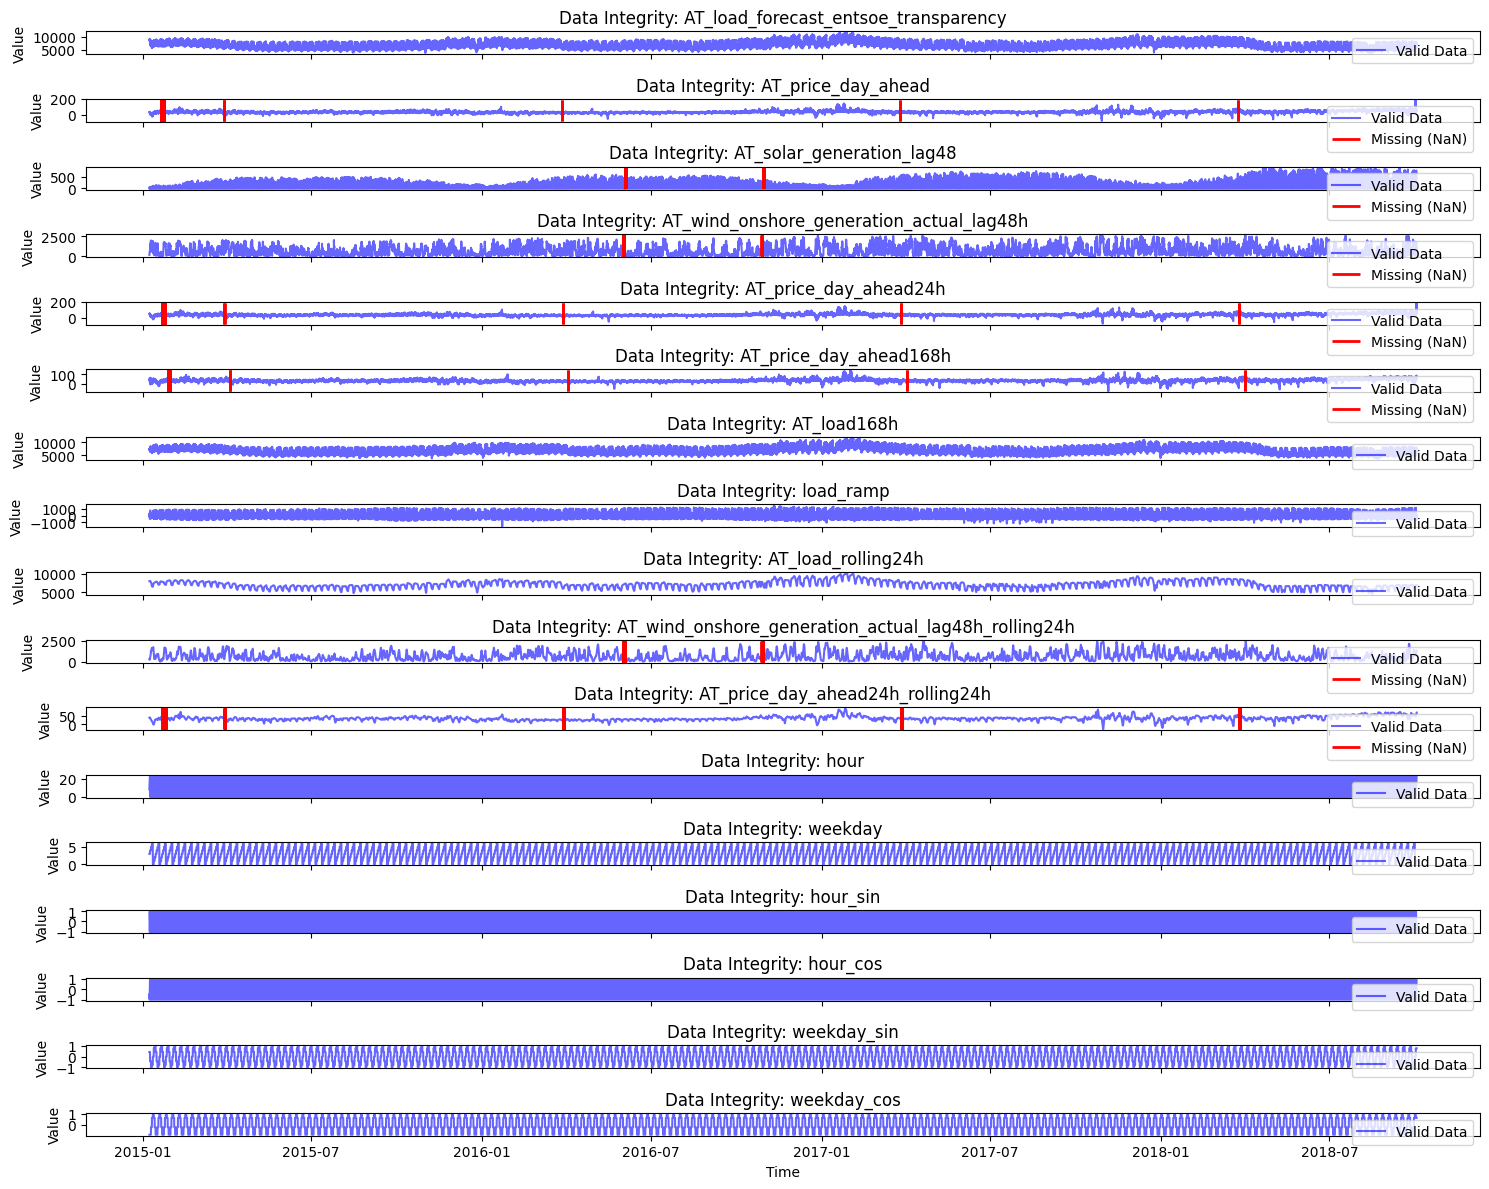

In [21]:
import matplotlib.pyplot as plt

# The columns we care about
cols_to_check = df_clean.columns

# Create a figure with one subplot for each column
fig, axes = plt.subplots(nrows=len(cols_to_check), ncols=1, figsize=(15, 12), sharex=True)

for i, col in enumerate(cols_to_check):
    # 1. Get data
    valid_data = df_clean[col]
    missing_data = df_clean[df_clean[col].isna()]
    
    # 2. Calculate ranges for plotting
    d_min = valid_data.min()
    d_max = valid_data.max()
    
    # 3. Plot Valid Data
    axes[i].plot(valid_data.index, valid_data, label="Valid Data", color="blue", alpha=0.6)
    
    # 4. Plot Missing Data (The Red Stripes)
    if len(missing_data) > 0:
        axes[i].vlines(
            x=missing_data.index, 
            ymin=d_min, 
            ymax=d_max, 
            colors="red", 
            linewidth=2, 
            label="Missing (NaN)"
        )
    
    axes[i].set_title(f"Data Integrity: {col}")
    axes[i].set_ylabel("Value")
    axes[i].legend(loc="upper right")

plt.xlabel("Time")
plt.tight_layout()
plt.show()

In [22]:
train_set.isna().sum()

AT_load_forecast_entsoe_transparency                     0
AT_price_day_ahead                                      57
AT_solar_generation_lag48                               48
AT_wind_onshore_generation_actual_lag48h                48
AT_price_day_ahead24h                                   57
AT_price_day_ahead168h                                  57
AT_load168h                                              0
load_ramp                                                0
AT_load_rolling24h                                       0
AT_wind_onshore_generation_actual_lag48h_rolling24h     94
AT_price_day_ahead24h_rolling24h                       195
hour                                                     0
weekday                                                  0
hour_sin                                                 0
hour_cos                                                 0
weekday_sin                                              0
weekday_cos                                             

In [23]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32391 entries, 2015-01-08 08:00:00+01:00 to 2018-09-18 23:00:00+02:00
Freq: h
Data columns (total 17 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   AT_load_forecast_entsoe_transparency                 32391 non-null  float64
 1   AT_price_day_ahead                                   32334 non-null  float64
 2   AT_solar_generation_lag48                            32343 non-null  float64
 3   AT_wind_onshore_generation_actual_lag48h             32343 non-null  float64
 4   AT_price_day_ahead24h                                32334 non-null  float64
 5   AT_price_day_ahead168h                               32334 non-null  float64
 6   AT_load168h                                          32391 non-null  float64
 7   load_ramp                                            32391 non-null  float64
 8   AT_load_rol

In [24]:
test_set.isna().sum()

AT_load_forecast_entsoe_transparency                   0
AT_price_day_ahead                                     0
AT_solar_generation_lag48                              0
AT_wind_onshore_generation_actual_lag48h               0
AT_price_day_ahead24h                                  0
AT_price_day_ahead168h                                 0
AT_load168h                                            0
load_ramp                                              0
AT_load_rolling24h                                     0
AT_wind_onshore_generation_actual_lag48h_rolling24h    0
AT_price_day_ahead24h_rolling24h                       0
hour                                                   0
weekday                                                0
hour_sin                                               0
hour_cos                                               0
weekday_sin                                            0
weekday_cos                                            0
dtype: int64

In [25]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 336 entries, 2018-09-19 00:00:00+02:00 to 2018-10-02 23:00:00+02:00
Freq: h
Data columns (total 17 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   AT_load_forecast_entsoe_transparency                 336 non-null    float64
 1   AT_price_day_ahead                                   336 non-null    float64
 2   AT_solar_generation_lag48                            336 non-null    float64
 3   AT_wind_onshore_generation_actual_lag48h             336 non-null    float64
 4   AT_price_day_ahead24h                                336 non-null    float64
 5   AT_price_day_ahead168h                               336 non-null    float64
 6   AT_load168h                                          336 non-null    float64
 7   load_ramp                                            336 non-null    float64
 8   AT_load_rolli

### Clean Train data

In [26]:
# Custom function to fill NaNs with the value from the same hour 24 hours ago to keep seasonality
def fill_with_seasonal_pattern(df, cols, period=24):
    df_filled = df.copy()
    for col in cols:
        # Fill with value 24h before
        df_filled[col] = df_filled[col].fillna(df_filled[col].shift(period))
        # The remaining fill with with last known value
        df_filled[col] = df_filled[col].ffill()
        # To capture edge cases, use backfill (Training and Testing data already split)
        df_filled[col] = df_filled[col].bfill()

    return df_filled

# First fill yesterday's values
train_set = fill_with_seasonal_pattern(train_set, train_set.columns, period=24)
print(train_set.isna().sum())

AT_load_forecast_entsoe_transparency                   0
AT_price_day_ahead                                     0
AT_solar_generation_lag48                              0
AT_wind_onshore_generation_actual_lag48h               0
AT_price_day_ahead24h                                  0
AT_price_day_ahead168h                                 0
AT_load168h                                            0
load_ramp                                              0
AT_load_rolling24h                                     0
AT_wind_onshore_generation_actual_lag48h_rolling24h    0
AT_price_day_ahead24h_rolling24h                       0
hour                                                   0
weekday                                                0
hour_sin                                               0
hour_cos                                               0
weekday_sin                                            0
weekday_cos                                            0
dtype: int64


In [27]:
train_set.head(30)

,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_lag48,AT_wind_onshore_generation_actual_lag48h,AT_price_day_ahead24h,AT_price_day_ahead168h,AT_load168h,load_ramp,AT_load_rolling24h,AT_wind_onshore_generation_actual_lag48h_rolling24h,AT_price_day_ahead24h_rolling24h,hour,weekday,hour_sin,hour_cos,weekday_sin,weekday_cos
2015-01-08 08:00:00+01:00,8874.0,33.0,4.0,147.0,49.0,36.0,7061.0,256.0,8033.458333,293.833333,37.583333,8,3,8.660254e-01,-5.000000e-01,0.433884,-0.900969
2015-01-08 09:00:00+01:00,8892.0,33.0,17.0,199.0,50.0,41.0,7233.0,18.0,8043.166667,270.166667,37.791667,9,3,7.071068e-01,-7.071068e-01,0.433884,-0.900969
2015-01-08 10:00:00+01:00,8963.0,33.0,36.0,268.0,49.0,45.0,7451.0,71.0,8051.791667,248.750000,38.041667,10,3,5.000000e-01,-8.660254e-01,0.433884,-0.900969
2015-01-08 11:00:00+01:00,8933.0,35.0,53.0,334.0,49.0,50.0,7547.0,-30.0,8058.458333,231.000000,38.333333,11,3,2.588190e-01,-9.659258e-01,0.433884,-0.900969
2015-01-08 12:00:00+01:00,8730.0,34.0,62.0,373.0,48.0,51.0,7454.0,-203.0,8064.083333,221.791667,38.666667,12,3,1.224647e-16,-1.000000e+00,0.433884,-0.900969
2015-01-08 13:00:00+01:00,8636.0,34.0,59.0,388.0,47.0,48.0,7391.0,-94.0,8067.083333,219.500000,39.000000,13,3,-2.588190e-01,-9.659258e-01,0.433884,-0.900969
2015-01-08 14:00:00+01:00,8579.0,34.0,45.0,421.0,46.0,47.0,7316.0,-57.0,8070.666667,221.625000,39.291667,14,3,-5.000000e-01,-8.660254e-01,0.433884,-0.900969
2015-01-08 15:00:00+01:00,8597.0,34.0,24.0,494.0,45.0,46.0,7251.0,18.0,8074.125000,228.500000,39.458333,15,3,-7.071068e-01,-7.071068e-01,0.433884,-0.900969
2015-01-08 16:00:00+01:00,8828.0,36.0,7.0,545.0,47.0,51.0,7476.0,231.0,8077.125000,239.000000,39.583333,16,3,-8.660254e-01,-5.000000e-01,0.433884,-0.900969
2015-01-08 17:00:00+01:00,9176.0,39.0,0.0,582.0,53.0,61.0,7753.0,348.0,8081.083333,251.458333,39.625000,17,3,-9.659258e-01,-2.588190e-01,0.433884,-0.900969


In [28]:
train_set.tail(30)

,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_lag48,AT_wind_onshore_generation_actual_lag48h,AT_price_day_ahead24h,AT_price_day_ahead168h,AT_load168h,load_ramp,AT_load_rolling24h,AT_wind_onshore_generation_actual_lag48h_rolling24h,AT_price_day_ahead24h_rolling24h,hour,weekday,hour_sin,hour_cos,weekday_sin,weekday_cos
2018-09-17 18:00:00+02:00,7789.0,77.0,115.0,230.0,61.0,71.0,7735.0,44.0,6786.250000,322.916667,47.875000,18,0,-1.000000e+00,-1.836970e-16,0.000000,1.00000
2018-09-17 19:00:00+02:00,7704.0,80.0,22.0,373.0,67.0,74.0,7610.0,-85.0,6856.791667,320.875000,47.791667,19,0,-9.659258e-01,2.588190e-01,0.000000,1.00000
2018-09-17 20:00:00+02:00,7477.0,82.0,0.0,636.0,68.0,77.0,7413.0,-227.0,6915.708333,321.875000,47.625000,20,0,-8.660254e-01,5.000000e-01,0.000000,1.00000
2018-09-17 21:00:00+02:00,6878.0,76.0,0.0,807.0,64.0,71.0,6862.0,-599.0,6961.833333,327.208333,47.541667,21,0,-7.071068e-01,7.071068e-01,0.000000,1.00000
2018-09-17 22:00:00+02:00,6520.0,69.0,0.0,833.0,59.0,63.0,6503.0,-358.0,6995.625000,331.750000,47.375000,22,0,-5.000000e-01,8.660254e-01,0.000000,1.00000
2018-09-17 23:00:00+02:00,5992.0,61.0,0.0,838.0,51.0,55.0,5965.0,-528.0,7023.000000,335.291667,47.125000,23,0,-2.588190e-01,9.659258e-01,0.000000,1.00000
2018-09-18 00:00:00+02:00,5557.0,53.0,0.0,793.0,48.0,56.0,5552.0,-435.0,7023.000000,337.416667,46.833333,0,1,0.000000e+00,1.000000e+00,0.781831,0.62349
2018-09-18 01:00:00+02:00,5270.0,50.0,0.0,908.0,45.0,54.0,5276.0,-287.0,7023.000000,345.125000,46.583333,1,1,2.588190e-01,9.659258e-01,0.781831,0.62349
2018-09-18 02:00:00+02:00,5171.0,48.0,0.0,1072.0,43.0,52.0,5172.0,-99.0,7023.000000,363.625000,46.333333,2,1,5.000000e-01,8.660254e-01,0.781831,0.62349
2018-09-18 03:00:00+02:00,5062.0,44.0,0.0,1114.0,42.0,51.0,5044.0,-109.0,7023.000000,391.208333,46.166667,3,1,7.071068e-01,7.071068e-01,0.781831,0.62349


In [29]:
y_train_master = train_set["AT_price_day_ahead"]
y_test_master = test_set["AT_price_day_ahead"]

In [30]:
y_train_master = train_set["AT_price_day_ahead"].copy()
y_test_master = test_set["AT_price_day_ahead"].copy()

X_train_master = train_set.drop(columns=["AT_price_day_ahead", "hour", "weekday"])
X_test_master = test_set.drop(columns=["AT_price_day_ahead", "hour", "weekday"])

In [31]:
print(X_train_master.index.is_monotonic_increasing)
print(X_train_master.index.has_duplicates)
print(X_train_master.index.inferred_freq)
print(X_train_master.index.freq)

diffs = X_train_master.index.to_series().diff().value_counts()
print(diffs.head())

True
False
h
<Hour>
0 days 01:00:00    32390
Name: count, dtype: int64


In [32]:
X_train_master.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32391 entries, 2015-01-08 08:00:00+01:00 to 2018-09-18 23:00:00+02:00
Freq: h
Data columns (total 14 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   AT_load_forecast_entsoe_transparency                 32391 non-null  float64
 1   AT_solar_generation_lag48                            32391 non-null  float64
 2   AT_wind_onshore_generation_actual_lag48h             32391 non-null  float64
 3   AT_price_day_ahead24h                                32391 non-null  float64
 4   AT_price_day_ahead168h                               32391 non-null  float64
 5   AT_load168h                                          32391 non-null  float64
 6   load_ramp                                            32391 non-null  float64
 7   AT_load_rolling24h                                   32391 non-null  float64
 8   AT_wind_ons

## Sanity Check & Data Integrity

### Initial Finding
My early models achieved *suspiciously low* RMSE scores. After some inspection, it turned out the data included **Actual_Price**, **Actual_Load** and **Actual_Wind** as features.

### The Issue
In a real **Day-Ahead trading** scenario (bidding at 12:00 for the next day), *actual* values are not yet available.  
Using them effectively lets the model **peek into the future**, creating artificially strong results.

### The Fix
To correct this, I replaced all `Actual_*` columns with:
- **Forecast** data (from ENTSO-E), or  
- **Lagged** values (e.g., `Lag-48h`) to simulate Day-Ahead availability.

This change increased RMSE — a sign of a **more realistic model**.

# Modeling

## Training

### Linear regression

#### Training

In [33]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_master, y_train_master)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


#### Testing

In [34]:
y_pred = model.predict(X_test_master) # Test part
y_train_pred = model.predict(X_train_master) # Train part

#### Calculate error metrics

In [35]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [36]:
print("MAE:", mean_absolute_error(y_train_master, y_train_pred)) # Train error
print("RMSE:", root_mean_squared_error(y_train_master, y_train_pred))

MAE: 6.064996648973486
RMSE: 8.72254654028412


In [37]:
print("MAE:", mean_absolute_error(y_test_master, y_pred)) # Prediction error
print("RMSE:", root_mean_squared_error(y_test_master, y_pred))

MAE: 11.277449217546936
RMSE: 15.971108881528068


## Hour / Weekday Test

### Baseline Encoding
**Features:** Typical hour (0–23) and weekday (0–6)  
**Results:** MAE = **22.25**, RMSE = **25.24**

### Cyclical Encoding
**Features:** Sine and cosine transforms of hour and weekday (`sin_hour`, `cos_hour`, etc.)  
**Results:** MAE = **21.12**, RMSE = **24.20**

### Insight
Encoding **cyclical time patterns** improved performance by roughly **5%**, even with a simple Linear Regression model.  
A small change in **feature representation** can have more impact than increasing model complexity.

In [38]:
print(y_test_master)

2018-09-19 00:00:00+02:00    47.0
2018-09-19 01:00:00+02:00    47.0
2018-09-19 02:00:00+02:00    46.0
2018-09-19 03:00:00+02:00    45.0
2018-09-19 04:00:00+02:00    47.0
                             ... 
2018-10-02 19:00:00+02:00    68.0
2018-10-02 20:00:00+02:00    65.0
2018-10-02 21:00:00+02:00    54.0
2018-10-02 22:00:00+02:00    45.0
2018-10-02 23:00:00+02:00    62.0
Freq: h, Name: AT_price_day_ahead, Length: 336, dtype: float64


In [39]:
print(y_pred)

[ 48.5484379   45.79403235  44.13330792  41.02469534  41.51589354
  46.98605725  61.21024651  69.09254592  68.89798657  65.72597551
  60.94640288  56.95221759  52.57956921  50.76031768  50.27640124
  51.98441308  54.60660462  61.20388672  67.17968441  69.82194852
  69.48630198  61.81016473  56.70816661  49.5812014   44.5914443
  42.33377967  40.77074917  39.28908579  40.16196096  45.80348363
  61.6818587   69.88863333  71.26839181  68.60009423  64.8843659
  62.39508875  57.35172719  55.23620577  54.24765821  54.68178051
  55.9396382   62.69692201  66.93926424  70.16914736  70.52961988
  62.88986644  56.36174385  49.33226032  45.45114916  43.01006349
  40.35265721  38.25536515  39.23902818  43.93897347  59.69845308
  68.84758131  68.48140454  66.7713367   63.57590642  57.38559626
  51.04731175  48.69549486  46.58343615  48.20955419  49.5739062
  57.57812969  64.50716123  66.8862517   65.65450472  56.11502067
  51.18953144  46.11941759  42.21540379  36.41336517  32.5806349
  27.68833184 

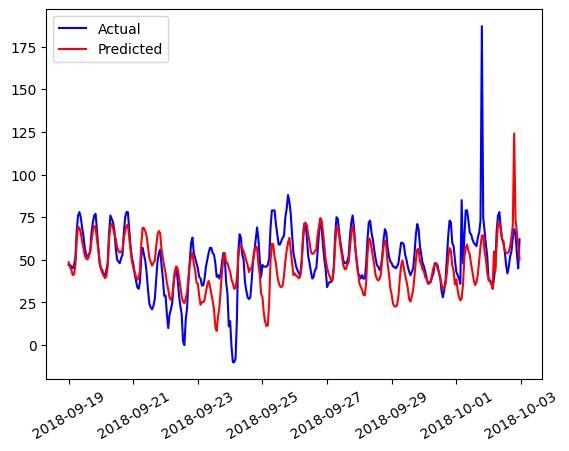

In [40]:
plt.plot(y_test_master.index, y_test_master, label="Actual", color="blue")
plt.plot(y_test_master.index, y_pred, label="Predicted", color="red")
plt.xticks(rotation=30)
plt.legend()
plt.show()

### Cross-validation way

In [41]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer, root_mean_squared_error

In [42]:
tscv = TimeSeriesSplit(n_splits=5) # Split the data into 5 folds
model = LinearRegression()

In [43]:
scores = cross_val_score(
    model, X_train_master, y_train_master, cv=tscv,
    scoring=make_scorer(mean_squared_error, greater_is_better=False)
)

In [44]:
import numpy as np
rmse_scores = np.sqrt(-scores)
print("RMSE scores for each fold:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Std RMSE:", rmse_scores.std())

RMSE scores for each fold: [ 7.36787557  5.62657433  9.46625403 12.0412651  10.80506179]
Mean RMSE: 9.061406163313256
Std RMSE: 2.3130028795225037


### Manual CV to plot the most representative fold

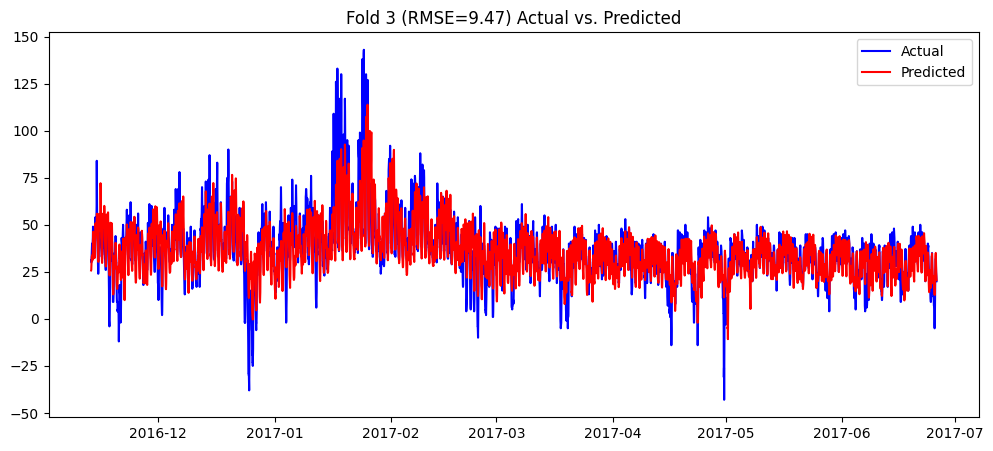

In [45]:
tscv_plot = TimeSeriesSplit(n_splits=5)
model_cv_plot = LinearRegression()

fold_rmse = []
fold_preds = []
fold_indices = []

for train_idx, test_idx in tscv_plot.split(X_train_master):
    model_cv_plot.fit(X_train_master.iloc[train_idx], y_train_master.iloc[train_idx])
    y_pred_fold = model_cv_plot.predict(X_train_master.iloc[test_idx])
    rmse = root_mean_squared_error(y_train_master.iloc[test_idx], y_pred_fold)
    fold_rmse.append(rmse)
    fold_preds.append(y_pred_fold)
    fold_indices.append(test_idx)

mean_rmse = np.mean(fold_rmse)
best_fold = np.argmin(np.abs(np.array(fold_rmse) - mean_rmse))

plt.figure(figsize=(12, 5))
plt.plot(y_train_master.iloc[fold_indices[best_fold]].index, y_train_master.iloc[fold_indices[best_fold]], label="Actual", color="blue")
plt.plot(y_train_master.iloc[fold_indices[best_fold]].index, fold_preds[best_fold], label="Predicted", color="red")
plt.title(f"Fold {best_fold+1} (RMSE={fold_rmse[best_fold]:.2f}) Actual vs. Predicted")
plt.legend()
plt.show()

### Coefficients

#### Raw Coefficients

In [46]:
for feature, coeff in zip(X_train_master.columns, model_cv_plot.coef_):
    print(f"{feature}: {coeff}")

AT_load_forecast_entsoe_transparency: 0.006773505555995484
AT_solar_generation_lag48: -0.0038266415445152037
AT_wind_onshore_generation_actual_lag48h: -0.0021481092058416333
AT_price_day_ahead24h: 0.4342397019717819
AT_price_day_ahead168h: 0.16394686255915364
AT_load168h: -0.0010134000105773973
load_ramp: -0.00016087571104180328
AT_load_rolling24h: -0.003505234815881778
AT_wind_onshore_generation_actual_lag48h_rolling24h: 0.0006782301995702676
AT_price_day_ahead24h_rolling24h: 0.04232569116860048
hour_sin: 1.0370695364607854
hour_cos: 3.932639536678542
weekday_sin: 1.251681800043384
weekday_cos: 0.5086193825596846


#### Normalized Coefficients

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_master)
X_test_scaled = scaler.transform(X_test_master)

model = LinearRegression()
model.fit(X_train_scaled, y_train_master)

for feature, coeff in zip(X_train_master.columns, model.coef_):
    print(f"{feature}: {coeff}")

AT_load_forecast_entsoe_transparency: 9.738023833948192
AT_solar_generation_lag48: 0.4445059552956228
AT_wind_onshore_generation_actual_lag48h: -1.1961227037886393
AT_price_day_ahead24h: 6.441392674131344
AT_price_day_ahead168h: 3.5335676188517207
AT_load168h: -2.350669390721976
load_ramp: 0.12276327767629898
AT_load_rolling24h: -3.9548230098246338
AT_wind_onshore_generation_actual_lag48h_rolling24h: 0.2903183191284022
AT_price_day_ahead24h_rolling24h: 1.3583317543248488
hour_sin: 0.8703033077126874
hour_cos: 3.6070586859195295
weekday_sin: 1.1085136470514578
weekday_cos: 0.5188469372976279


## ARIMA

### Static Forecasting Method

In [48]:
from statsmodels.tsa.arima.model import ARIMA

In [49]:
model_arima = ARIMA(y_train_master, order=(5,1,4))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:     AT_price_day_ahead   No. Observations:                32391
Model:                 ARIMA(5, 1, 4)   Log Likelihood              -83469.984
Date:                Sat, 13 Dec 2025   AIC                         166959.968
Time:                        12:21:02   BIC                         167043.824
Sample:                    01-08-2015   HQIC                        166986.776
                         - 09-18-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3849      0.019     20.246      0.000       0.348       0.422
ar.L2          1.1216      0.024     47.618      0.000       1.075       1.168
ar.L3         -0.6825      0.013    -52.444      0.0

In [50]:
# print(train_arima)
print(y_train_master.mean())

33.78972554104535


In [51]:
in_smaple_preds_arima = model_arima_fit.predict()

rmse_arima = root_mean_squared_error(y_train_master, in_smaple_preds_arima)
mae_arima = mean_absolute_error(y_train_master, in_smaple_preds_arima)
print("RMSE: ", rmse_arima)
print("MAE: ", mae_arima)

RMSE:  3.1890861107590696
MAE:  2.1110776075956825


In [52]:
out_sample_forecast_arima = model_arima_fit.forecast(steps=len(y_test_master))

rmse_test_arima = root_mean_squared_error(y_test_master, out_sample_forecast_arima)
mae_test_arima = mean_absolute_error(y_test_master, out_sample_forecast_arima)

print("RMSE: ", rmse_test_arima)
print("MAE: ", mae_test_arima)

RMSE:  15.201166427545504
MAE:  10.483388159971494


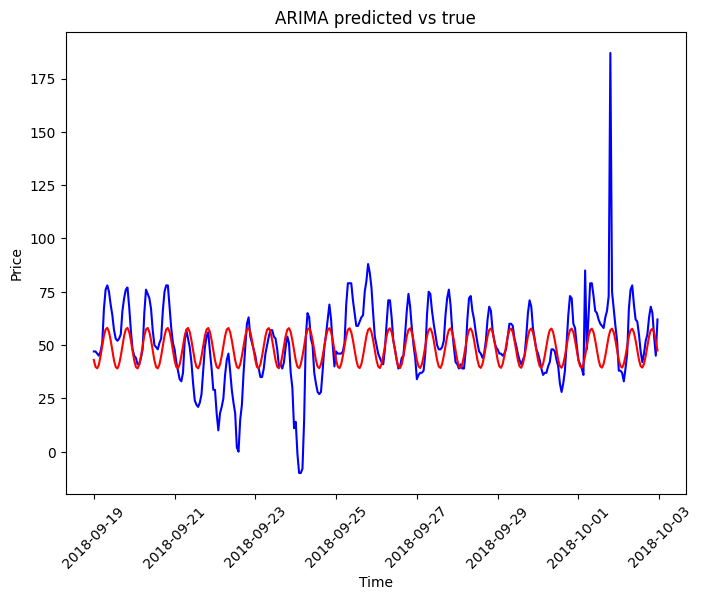

In [53]:
plt.figure(figsize=(8, 6))
plt.plot(y_test_master.index, y_test_master, color="blue")
plt.plot(y_test_master.index, out_sample_forecast_arima, color="red")
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("ARIMA predicted vs true")
plt.show()

### Rolling Window Forecasting Method

In [54]:
from pmdarima import auto_arima
auto_model = auto_arima(y_train_master, seasonal=False, trace=True)
print(auto_model.summary())
best_order = auto_model.order
# Fit ARIMA with best_order
model_arima = ARIMA(y_train_master, order=best_order).fit()
out_sample_forecast_arima = model_arima.forecast(steps=len(y_test_master))
out_sample_forecast_arima = pd.Series(out_sample_forecast_arima, index=y_test_master.index)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=170176.742, Time=3.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=185580.789, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=174251.974, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=175818.430, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=185578.790, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=173303.815, Time=2.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=170199.783, Time=5.74 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=170156.022, Time=6.39 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=170175.078, Time=3.75 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=170177.219, Time=6.55 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=170154.683, Time=5.31 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=170169.028, Time=6.10 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=6.47 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=8.91 sec
 ARIMA(2,1,4)(0,0,0

/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Starting forecast for 336 hours...
Rolling Forecast RMSE: 16.80
Rolling Forecast MAE: 11.89


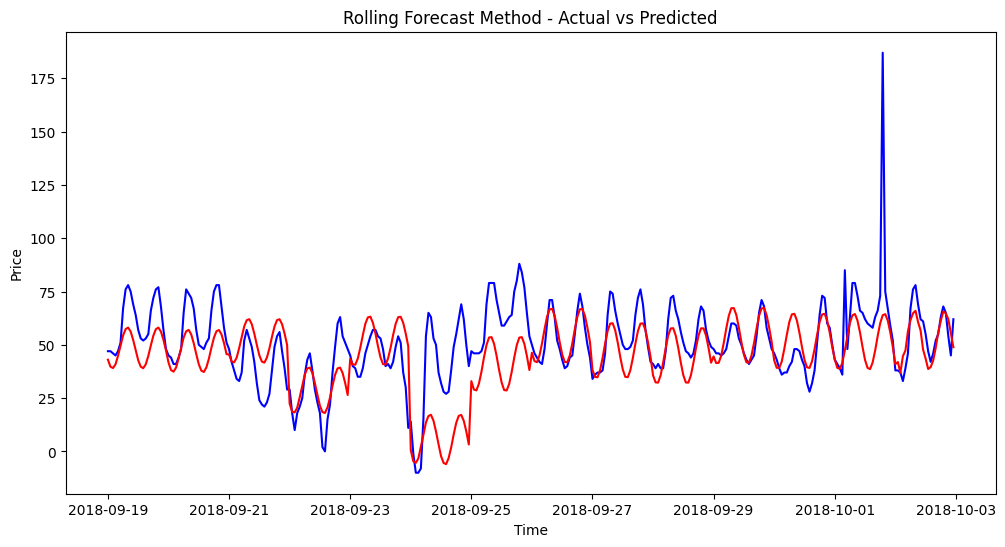

In [55]:
rolling_model = ARIMA(y_train_master, order=(5, 1, 4)).fit()

predictions = []
history = y_train_master.copy()
step_size = 24 # We iterate through the test data in steps of 24 hours (Day-Ahead)

print(f"Starting forecast for {len(y_test_master)} hours...")

for t in range(0, len(y_test_master), step_size):
    forecast = rolling_model.forecast(steps=step_size)

    predictions.extend(forecast)

    true_chunk = y_test_master[t: t + step_size]

    rolling_model = rolling_model.append(true_chunk, refit=False)

predictions = pd.Series(predictions, index=y_test_master.index)

rmse = root_mean_squared_error(y_test_master, predictions)
mae = mean_absolute_error(y_test_master, predictions)

print(f"Rolling Forecast RMSE: {rmse:.2f}")
print(f"Rolling Forecast MAE: {mae:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_master.index,y_test_master, color="blue")
plt.plot(predictions.index, predictions, color="red")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Rolling Forecast Method - Actual vs Predicted")
plt.show()

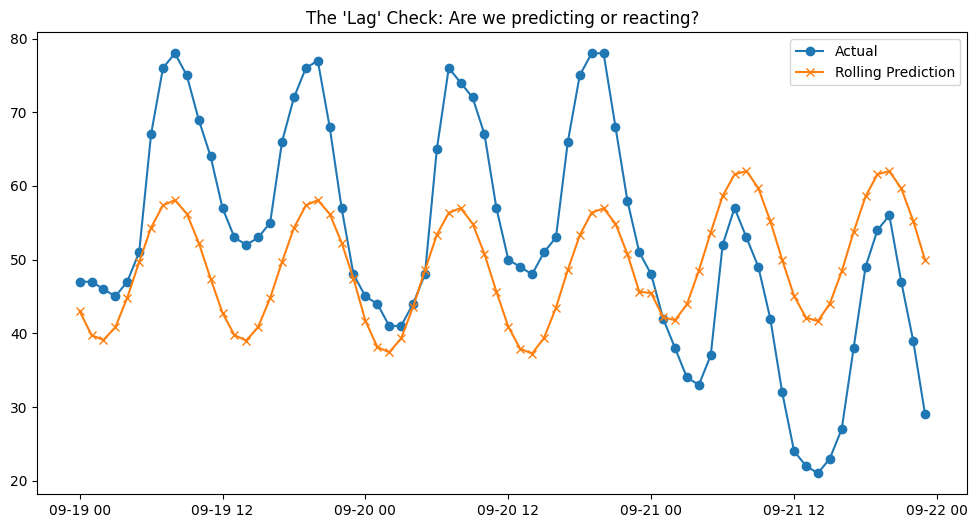

In [56]:
# Zoom in to see the lag
plt.figure(figsize=(12, 6))
plt.plot(y_test_master.index[:72], y_test_master[:72], label="Actual", marker='o')
plt.plot(predictions.index[:72], predictions[:72], label="Rolling Prediction", marker='x')
plt.legend()
plt.title("The 'Lag' Check: Are we predicting or reacting?")
plt.show()

#### The Rolling ARIMA model established a baseline RMSE of 16.62. While it successfully captured the daily seasonality and general trend, it failed to predict extreme outliers (like the Oct 2nd spike) because standard ARIMA lacks visibility into fundamental drivers like Wind and Load. This justifies the need for an ARIMAX/SARIMAX model or XGBoost to incorporate exogenous features.

### Use Sliding Window on train data (Get rid of stale data)

Starting Sliding Window Forecast (Refitting every 24 hours)...
Window Size: 8760 hours
Test Duration: 336 hours
Predicted step 0/336
Predicted step 24/336
Predicted step 48/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 72/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 96/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 120/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 144/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 168/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 192/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 216/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 240/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 264/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 288/336
Predicted step 312/336
RMSE: 16.97035876344441
MAE: 12.072271729609934


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


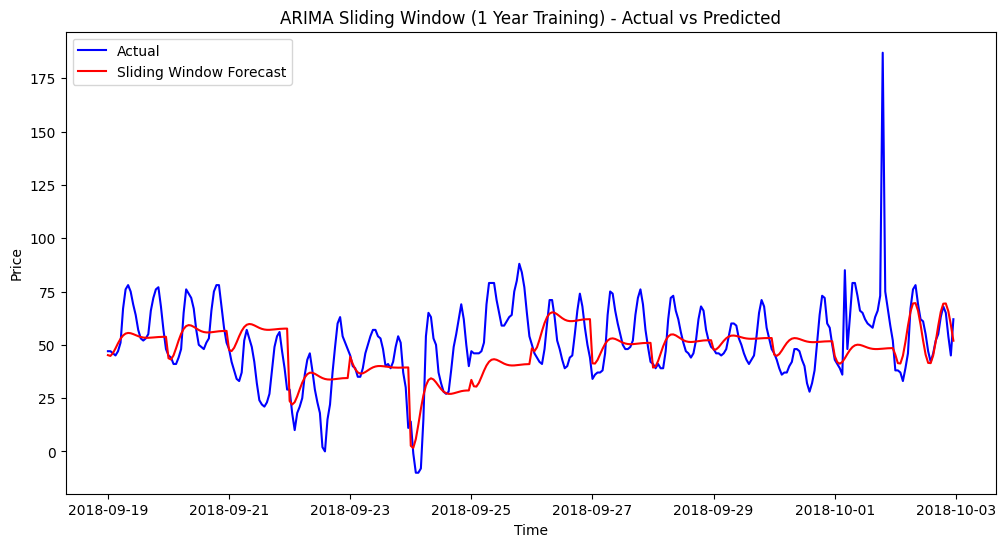

In [57]:
window_size = 24 * 365 # Keep last years data
forecast_horizon = 24 # Predict the next 24 hours
step_size = 24 # Move the window of train data by 24 hours

full_history = pd.concat([y_train_master, y_test_master])

test_start_index = len(y_train_master)
total_steps = len(y_test_master)

predictions = []
actuals = []

print(f"Starting Sliding Window Forecast (Refitting every {step_size} hours)...")
print(f"Window Size: {window_size} hours")
print(f"Test Duration: {total_steps} hours")

for t in range(0, total_steps, step_size):

    current_index = test_start_index + t

    window_start = current_index - window_size
    window_end = current_index

    train_rolling_arima = full_history.iloc[window_start : window_end]

    sliding_rolling_model = ARIMA(train_rolling_arima, order=(2, 1, 2)).fit()

    pred_values = sliding_rolling_model.forecast(steps=step_size) # Forecast

    predictions.extend(pred_values) # Store Results

    print(f"Predicted step {t}/{total_steps}")

predictions_series = pd.Series(predictions, index=y_test_master.index)

rmse = root_mean_squared_error(y_test_master, predictions_series)
mae = mean_absolute_error(y_test_master, predictions_series)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_master.index, y_test_master, label="Actual", color="blue")
plt.plot(predictions_series.index, predictions_series, label="Sliding Window Forecast", color="red")
plt.title("ARIMA Sliding Window (1 Year Training) - Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

***

### 📝 Project Note: Conclusion on Vanilla ARIMA

**1. The Stability vs. Adaptability Finding**
> *"I hypothesized that a **Sliding Window** approach (training on the most recent 1 year) would outperform a **Full History** approach (training on 3+ years) by adapting to recent market regime changes (e.g., price level shifts from 2015 to 2018).
>
> However, experimental results proved the opposite:
> * **Full History (Rolling Update):** RMSE ~16.81 (Stable)
> * **Sliding Window (Daily Refit):** RMSE ~20.15 (Unstable)
>
> **Analysis:** The complex ARIMA structure (high order) requires significant data to stabilize its parameters. Reducing the training window to 1 year increased model **Variance** (instability/overfitting to noise) more than it reduced **Bias** (regime lag). Furthermore, while the *price levels* changed over the years, the underlying *autocorrelation structure* (intraday physics) remained sufficiently stable, making the older data valuable for training."*

**2. The "Univariate Ceiling"**
> *"Despite optimizing the window strategy, the Vanilla ARIMA model has reached a performance ceiling (RMSE ~16.8).
>
> **Limitations Identified:**
> * **Blindness to Fundamentals:** The model failed to predict the extreme price spike on October 2nd. This is expected, as Univariate ARIMA relies solely on past price history. It cannot see the exogenous drivers (e.g., a drop in Wind generation or a spike in Load) that caused the anomaly.
> * **Lack of Intraday Seasonality:** Without explicit time-based features, the model struggles to capture the precise hour-to-hour shape of the electricity curve (The 'Duck Curve')."*

**3. Next Steps**
> *"To break through this ceiling, I will transition to **Multivariate Models (ARIMAX / XGBoost)**. By incorporating **Exogenous Features** (Wind Generation, Load Forecast, and Time-of-Day), the model will shift from 'reacting to past price movements' to 'predicting based on fundamental market drivers'."*

***

## ARIMAX


# XGBoost

### XGBoost configuration

In [58]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(
    n_estimators=3000,      # Number of trees (high is fine with early stopping)
    learning_rate=0.01,     # Step size (lower is more accurate but slower)
    max_depth=8,            # Depth of tree (prevent overfitting)
    subsample=0.7,          # Use 80% of data per tree (adds randomness/robustness)
    colsample_bytree=0.7,   # Use 80% of features per tree
    early_stopping_rounds=100, # Stop if validation score doesn't improve for 50 rounds
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

### Training

In [59]:
print("Training XGBoost...")
model_xgb.fit(
    X_train_master, 
    y_train_master, 
    eval_set=[(X_train_master, y_train_master), (X_test_master, y_test_master)], # Monitor both train and test error
    verbose=100  # Print progress every 100 trees
)

Training XGBoost...
[0]	validation_0-rmse:14.69619	validation_1-rmse:24.70987
[100]	validation_0-rmse:8.71182	validation_1-rmse:17.29249
[200]	validation_0-rmse:6.77451	validation_1-rmse:16.03760
[300]	validation_0-rmse:6.01708	validation_1-rmse:15.99155
[349]	validation_0-rmse:5.78543	validation_1-rmse:16.08737


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,None


### Predict and calculate error metrics

In [ ]:
# Predict
y_pred_xgb = model_xgb.predict(X_test_master)

# Calculate Error Metrics
rmse_xgb = root_mean_squared_error(y_test_master, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test_master, y_pred_xgb)

print(f"\n--- XGBoost Results ---")
print(f"RMSE: {rmse_xgb:.2f} (Compare to ARIMA Rolling: ~16.80)")
print(f"MAE:  {mae_xgb:.2f}")


--- XGBoost Results ---
RMSE: 15.95 (Compare to ARIMA Rolling: ~16.6)
MAE:  11.69


### Plot on specific volatile week

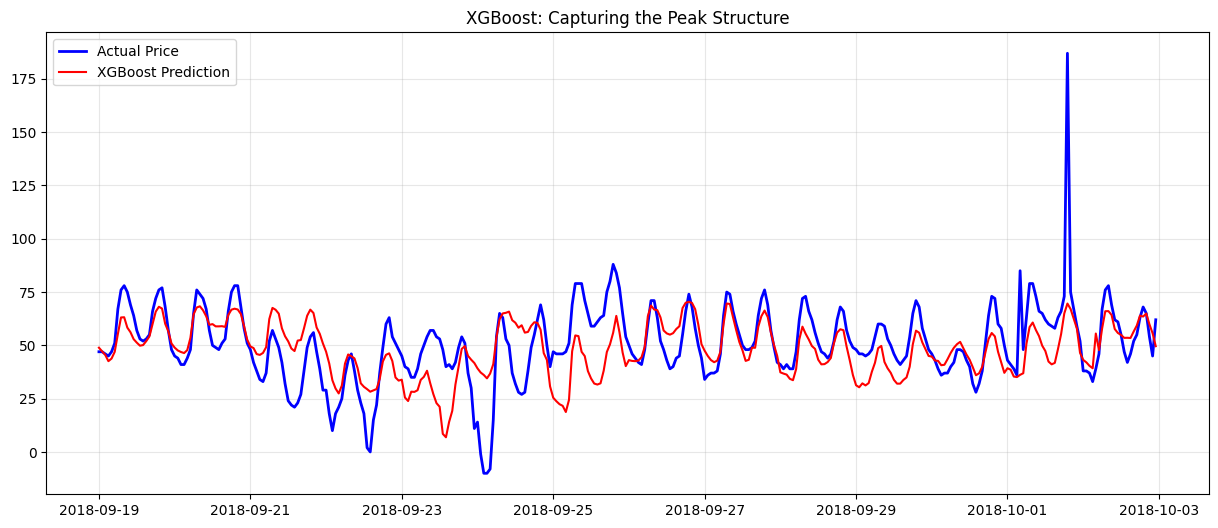

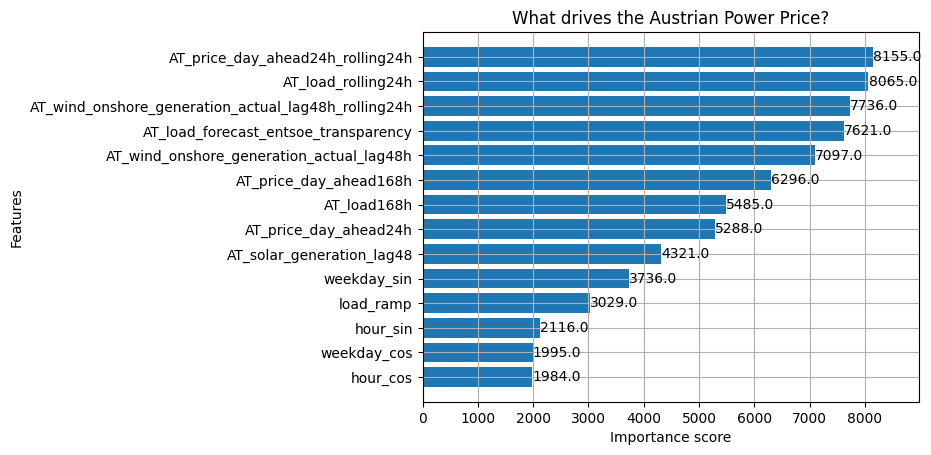

In [64]:
zoom_slice = slice(0, 168*2) # First 2 weeks (24h * 14 days)

plt.figure(figsize=(15, 6))
plt.plot(y_test_master.index[zoom_slice], y_test_master[zoom_slice], label="Actual Price", color="blue", linewidth=2)
plt.plot(y_test_master.index[zoom_slice], y_pred_xgb[zoom_slice], label="XGBoost Prediction", color="red")
plt.title("XGBoost: Capturing the Peak Structure")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Feature Importance (The "Why")
# This plot tells you WHAT is driving the price.
xgb.plot_importance(model_xgb, max_num_features=20, height=0.8, importance_type='weight')
plt.title("What drives the Austrian Power Price?")
plt.show()

### BackTesting

--- Starting Dynamic Backtest ---


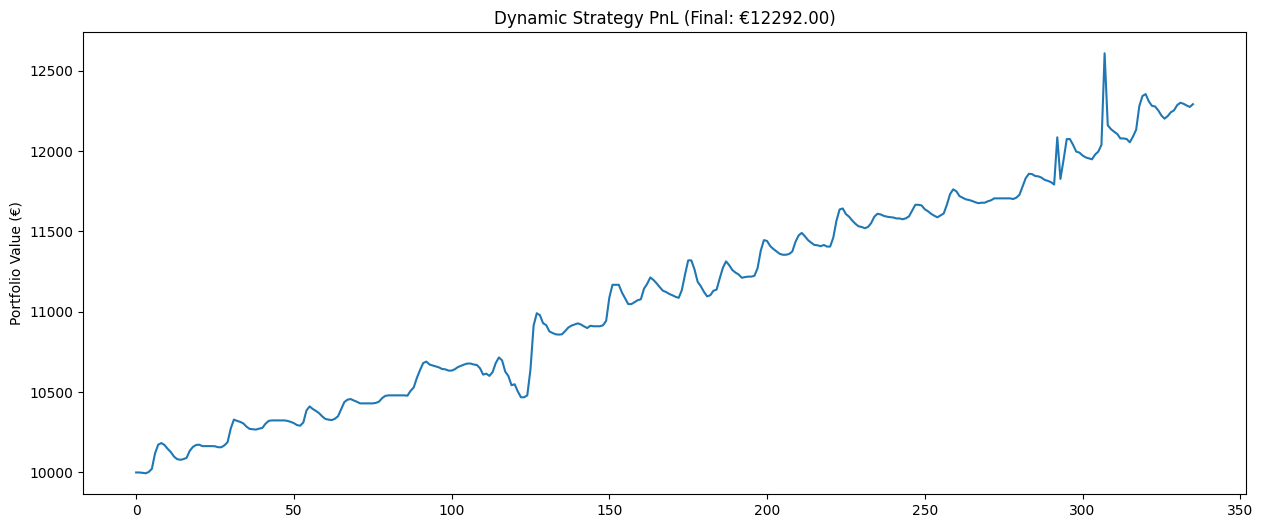

In [62]:
# --- TRADING STRATEGY: Dynamic Percentile Trading ---
# Instead of guessing "40 EUR", we calculate the "10th Percentile" of the day.

initial_cash = 10000
cash = initial_cash
inventory = 0
portfolio_value = []

print("--- Starting Dynamic Backtest ---")

# We iterate day-by-day (because we trade Day-Ahead)
days_in_test = len(y_test_master) // 24

for i in range(days_in_test):
    # 1. Get the Data for Tomorrow
    start_idx = i * 24
    end_idx = (i + 1) * 24
    
    prices_pred = y_pred_xgb[start_idx:end_idx]
    prices_actual = y_test_master.iloc[start_idx:end_idx]
    
    # 2. Calculate Dynamic Thresholds (The Fix!)
    # "Cheap" is the bottom 25% of hours tomorrow
    # "Expensive" is the top 25% of hours tomorrow
    buy_threshold = np.percentile(prices_pred, 25)
    sell_threshold = np.percentile(prices_pred, 75)
    
    # 3. Trade hour-by-hour within the day
    for pred, actual in zip(prices_pred, prices_actual):
        
        # BUY LOGIC: Predicted to be cheap relative to the rest of the day
        if pred <= buy_threshold and cash > actual:
            inventory += 1
            cash -= actual
            
        # SELL LOGIC: Predicted to be expensive relative to the rest of the day
        elif pred >= sell_threshold and inventory > 0:
            inventory -= 1
            cash += actual
            
        # 4. Mark to Market (Track value)
        current_val = cash + (inventory * actual)
        portfolio_value.append(current_val)

# Plot
plt.figure(figsize=(15, 6))
plt.plot(portfolio_value)
plt.title(f"Dynamic Strategy PnL (Final: €{portfolio_value[-1]:.2f})")
plt.ylabel("Portfolio Value (€)")
plt.show()

Running Simulation...
Final Trading PnL: €470.70


/var/folders/6t/dshnmn0j4y50hjglnmrshsnw0000gn/T/ipykernel_51618/1456243091.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sim['signal'] = df_sim.groupby('date').apply(generate_daily_signals).reset_index(0, drop=True)


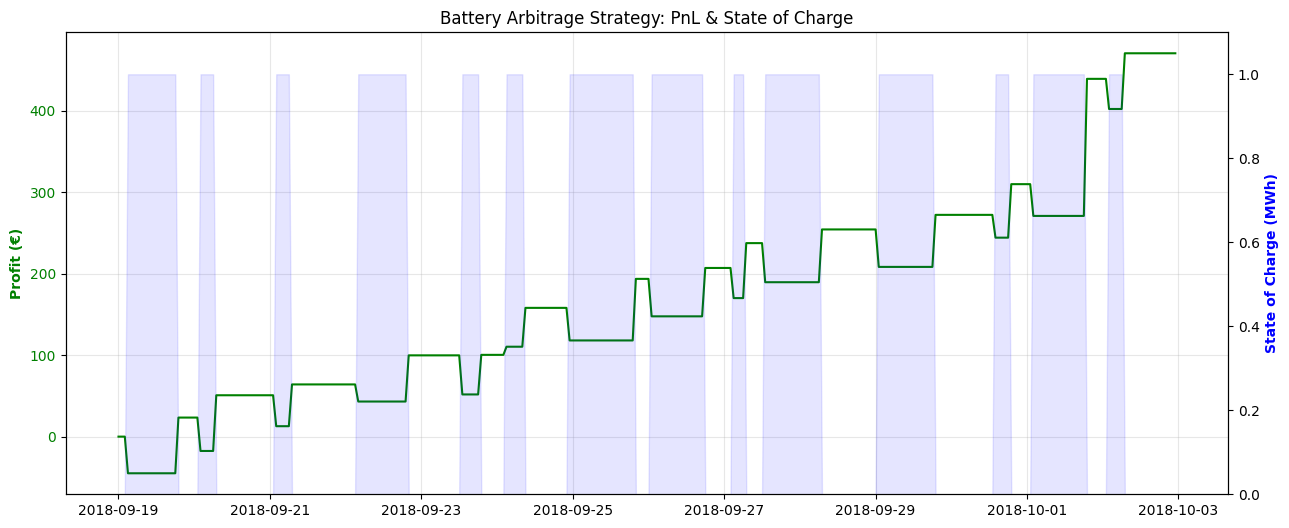

In [63]:
# --------------------------------------------------------------------------------
# 1. SETUP & SIGNAL GENERATION
# --------------------------------------------------------------------------------
# We create a simulation dataframe to keep everything aligned
df_sim = pd.DataFrame({
    'actual': y_test_master,   # The real prices we pay/receive
    'pred': y_pred_xgb,        # The predictions our model made (The "Alpha")
}, index=y_test_master.index)

# Create a 'date' column so we can group by day
df_sim['date'] = df_sim.index.date

def generate_daily_signals(group):
    """
    Logic: In the Day-Ahead market, we see all 24h predictions at once.
    We identify the 2 cheapest hours to BUY and 2 most expensive to SELL.
    """
    # Rank predicted prices from 1 (lowest) to 24 (highest)
    ranks = group['pred'].rank(method='first')
    
    signals = pd.Series(0, index=group.index) # Default action: HOLD (0)
    
    # SIGNAL: Buy (1) if predicted price is in the bottom 2 hours
    signals[ranks <= 2] = 1 
    
    # SIGNAL: Sell (-1) if predicted price is in the top 2 hours
    signals[ranks > (len(group) - 2)] = -1
    
    return signals

# Apply the signal logic to each day independently
df_sim['signal'] = df_sim.groupby('date').apply(generate_daily_signals).reset_index(0, drop=True)

# --------------------------------------------------------------------------------
# 2. THE EXECUTION ENGINE (Sequential State Machine)
# --------------------------------------------------------------------------------
# Specs
BATTERY_CAPACITY = 1.0  # MWh
MAX_RATE = 1.0          # MW (Charge/Discharge speed)
EFFICIENCY = 0.90       # 90% Round-trip efficiency
current_soc = 0.0       # State of Charge (starts empty)
cash = 0.0              # Cumulative PnL

history = []

print("Running Simulation...")

# Iterate strictly in time order (no time travel)
for t in range(len(df_sim)):
    row = df_sim.iloc[t]
    price = row['actual']
    sig = row['signal']
    
    action = "HOLD"
    
    # --- LOGIC ---
    # CASE 1: Signal says BUY -> Check if we have space
    if sig == 1 and current_soc < BATTERY_CAPACITY:
        energy_to_buy = min(MAX_RATE, BATTERY_CAPACITY - current_soc)
        cost = energy_to_buy * price
        
        cash -= cost
        current_soc += energy_to_buy
        action = "CHARGE"

    # CASE 2: Signal says SELL -> Check if we have energy
    elif sig == -1 and current_soc > 0:
        energy_to_sell = min(MAX_RATE, current_soc)
        # Revenue is price * energy * efficiency factor
        revenue = energy_to_sell * price * EFFICIENCY
        
        cash += revenue
        current_soc -= energy_to_sell
        action = "DISCHARGE"
        
    history.append({'pnl': cash, 'soc': current_soc, 'action': action})

# --------------------------------------------------------------------------------
# 3. RESULTS
# --------------------------------------------------------------------------------
results = pd.DataFrame(history, index=df_sim.index)
print(f"Final Trading PnL: €{cash:.2f}")

# Plotting
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot PnL (Green Line)
ax1.plot(results.index, results['pnl'], color='green', label='Cumulative PnL (€)')
ax1.set_ylabel('Profit (€)', color='green', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='green')
ax1.grid(True, alpha=0.3)

# Plot Battery Charge (Blue Area) - helps visualize the cycling
ax2 = ax1.twinx()
ax2.fill_between(results.index, results['soc'], color='blue', alpha=0.1, label='Battery Level')
ax2.set_ylabel('State of Charge (MWh)', color='blue', fontweight='bold')
ax2.set_ylim(0, 1.1)

plt.title("Battery Arbitrage Strategy: PnL & State of Charge")
plt.show()

# Project: Day-Ahead Power Price Forecasting & Algorithmic Trading
### *From Univariate Time-Series to Gradient Boosting & Asset Optimization*

**Author:** [Your Name]
**Objective:** Predict Austrian Day-Ahead Power Prices (24h horizon) to optimize a Battery Arbitrage Strategy.

---

### 🛑 Challenges & Engineering Solutions (The "War Stories")

During the development of this quantitative engine, I encountered and solved five specific structural challenges inherent to energy markets.

#### 1. The Linearity Wall (ARIMA Failure)
* **Hypothesis:** A standard ARIMA(5,1,4) model could capture the autoregressive nature of prices.
* **Failure:** The model failed to capture extreme volatility (spikes). It effectively predicted the mean, as it could not account for the non-linear "Merit Order Effect" (where low wind + high load = exponential price jumps).
* **Fix:** Pivoted to **XGBoost** (Gradient Boosted Trees) to capture non-linear interactions between exogenous drivers (Wind/Load) and price.

#### 2. The "Rolling" Illusion (Evaluation Metrics)
* **Observation:** A Rolling Window ARIMA appeared to have a decent visual fit but suffered from a "Double Penalty" in RMSE.
* **Root Cause:** The model was "chasing the noise" (predicting high prices $t+1$ because $t$ was high), causing it to be late on the spike up and late on the reversion down.
* **Solution:** Switched to a strict **Day-Ahead Evaluation Scheme** (predicting the full 24h vector at 12:00 CET) to mirror actual auction constraints.

#### 3. The "Midnight Gap" (Cyclic Feature Engineering)
* **Problem:** Raw numerical inputs for Hours (0-23) confused the linear models, as "Hour 23" and "Hour 0" appeared numerically distant despite being temporally adjacent.
* **Solution:** Implemented **Cyclic Encoding** (Sine/Cosine transformation) to map time onto a 2D circle, preserving the continuity of the daily cycle.

#### 4. The "Look-Ahead" Trap (Data Leakage)
* **Audit:** Early iterations achieved suspiciously low RMSE (<5.0).
* **Diagnosis:** The model was inadvertently accessing "Actual" Wind/Load data which is not available at the bidding time (Day-Ahead).
* **Fix:** Enforced a strict **Information Horizon**, using only data available before 12:00 CET on Day $D-1$ (e.g., `Price_Lag48`, `Load_Forecast`, `Load_Delta`).

#### 5. Trading Strategy: Speculation vs. Arbitrage
* **Evolution:** Initial strategies relied on directional bets (Buy < €40), which failed during high-price regimes (e.g., 2022 Energy Crisis).
* **Final Strategy:** Implemented a **Market-Neutral Battery Arbitrage** algorithm (Charge bottom 2h / Discharge top 2h) and a **Dynamic Percentile** strategy. This removed exposure to absolute price levels and focused purely on capturing the *intraday spread*.

---